# Apply Long Short-Term Memory (LSTM) networks to trian and predict for ED daily arrivals

In [1]:
## Load packages
import tensorflow as tf
from tensorflow import keras
import tensorflow.python.keras.backend as K
from tensorflow.keras import backend
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

from keras import backend
import numpy as np
import matplotlib.pyplot as plt

from pandas import read_csv
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import pandas as pd

ModuleNotFoundError: No module named 'tensorflow'

In [2]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [2]:
# load the dataset
dataframe = read_csv('time series data.csv', usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')

NameError: name 'read_csv' is not defined

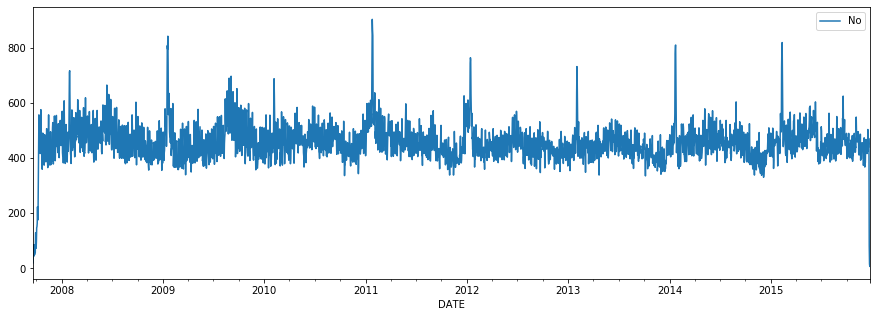

In [4]:
## plot a time series line plot.
df = pd.read_csv("Linkou.csv")

## drop the columns we don’t need, then convert “Date” column to datatime data type and set “Date” column to index
##df.drop(['temp', 'humi', 'workday', 'weekend', 'single_day', 'ch_year_low', 'ch_year_high', 'holiday_low', 'holiday_high', 'seasonal', 'temd1', 'temd2', 'temd3'], axis=1, inplace=True)
df['DATE'] = pd.to_datetime(df['DATE'])
ind_df = df.set_index(['DATE'])
ind_df.head()

#df.DATE = pd.to_datetime(df.DATE)
#df = df.set_index("DATE")
#df.head()

ind_df = ind_df.sort_index()
plt.rcParams["figure.figsize"] = (15,5)
ind_df.plot()

In [5]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [6]:
# split into train and test sets
test_size = 365
train_size = len(dataset) - test_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [7]:
# reshape into X=t and Y=t+1
look_back = 30
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [8]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [9]:
# create and fit the LSTM network
#K.get_graph()
#model = tf.keras.Sequential()
#model.add(LSTM(4, input_shape=(1, look_back)))
#model.add(Dense(1))
#model.compile(loss='mean_squared_error', optimizer='adam')
#model.fit(trainX, trainY, epochs=300, batch_size=3, verbose=1)

model = Sequential()
model.add(LSTM(50, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history=model.fit(trainX, trainY, epochs=1000, batch_size=30, validation_data=(testX, testY), verbose=1)

Epoch 1/1000
88/88 [==============================] - 1s 8ms/step - loss: 0.0343 - val_loss: 0.0052
Epoch 2/1000
88/88 [==============================] - 0s 3ms/step - loss: 0.0034 - val_loss: 0.0051
Epoch 3/1000
88/88 [==============================] - 0s 3ms/step - loss: 0.0033 - val_loss: 0.0050
Epoch 4/1000
88/88 [==============================] - 0s 3ms/step - loss: 0.0031 - val_loss: 0.0048
Epoch 5/1000
88/88 [==============================] - 0s 4ms/step - loss: 0.0030 - val_loss: 0.0048
Epoch 6/1000
88/88 [==============================] - 0s 3ms/step - loss: 0.0028 - val_loss: 0.0046
Epoch 7/1000
88/88 [==============================] - 0s 3ms/step - loss: 0.0027 - val_loss: 0.0044
Epoch 8/1000
88/88 [==============================] - 0s 3ms/step - loss: 0.0025 - val_loss: 0.0043
Epoch 9/1000
88/88 [==============================] - 0s 3ms/step - loss: 0.0024 - val_loss: 0.0042
Epoch 10/1000
88/88 [==============================] - 0s 3ms/step - loss: 0.0023 - val_loss: 0.0040

88/88 [==============================] - 0s 3ms/step - loss: 0.0016 - val_loss: 0.0029
Epoch 163/1000
88/88 [==============================] - 0s 4ms/step - loss: 0.0016 - val_loss: 0.0028
Epoch 164/1000
88/88 [==============================] - 0s 4ms/step - loss: 0.0017 - val_loss: 0.0029
Epoch 165/1000
88/88 [==============================] - 0s 4ms/step - loss: 0.0016 - val_loss: 0.0029
Epoch 166/1000
88/88 [==============================] - 0s 3ms/step - loss: 0.0016 - val_loss: 0.0029
Epoch 167/1000
88/88 [==============================] - 0s 4ms/step - loss: 0.0016 - val_loss: 0.0030
Epoch 168/1000
88/88 [==============================] - 0s 3ms/step - loss: 0.0016 - val_loss: 0.0029
Epoch 169/1000
88/88 [==============================] - 0s 3ms/step - loss: 0.0016 - val_loss: 0.0029
Epoch 170/1000
88/88 [==============================] - 0s 3ms/step - loss: 0.0016 - val_loss: 0.0030
Epoch 171/1000
88/88 [==============================] - 0s 3ms/step - loss: 0.0016 - val_loss: 0.

88/88 [==============================] - 0s 4ms/step - loss: 0.0016 - val_loss: 0.0034
Epoch 323/1000
88/88 [==============================] - 0s 5ms/step - loss: 0.0015 - val_loss: 0.0030
Epoch 324/1000
88/88 [==============================] - 0s 5ms/step - loss: 0.0015 - val_loss: 0.0031
Epoch 325/1000
88/88 [==============================] - 0s 4ms/step - loss: 0.0015 - val_loss: 0.0030
Epoch 326/1000
88/88 [==============================] - 0s 4ms/step - loss: 0.0015 - val_loss: 0.0030
Epoch 327/1000
88/88 [==============================] - 0s 4ms/step - loss: 0.0015 - val_loss: 0.0032
Epoch 328/1000
88/88 [==============================] - 0s 4ms/step - loss: 0.0015 - val_loss: 0.0030
Epoch 329/1000
88/88 [==============================] - 0s 4ms/step - loss: 0.0015 - val_loss: 0.0030
Epoch 330/1000
88/88 [==============================] - 0s 4ms/step - loss: 0.0015 - val_loss: 0.0030
Epoch 331/1000
88/88 [==============================] - 0s 4ms/step - loss: 0.0015 - val_loss: 0.

88/88 [==============================] - 0s 3ms/step - loss: 0.0015 - val_loss: 0.0034
Epoch 483/1000
88/88 [==============================] - 0s 3ms/step - loss: 0.0015 - val_loss: 0.0030
Epoch 484/1000
88/88 [==============================] - 0s 3ms/step - loss: 0.0014 - val_loss: 0.0031
Epoch 485/1000
88/88 [==============================] - 0s 3ms/step - loss: 0.0015 - val_loss: 0.0030
Epoch 486/1000
88/88 [==============================] - 0s 3ms/step - loss: 0.0014 - val_loss: 0.0030
Epoch 487/1000
88/88 [==============================] - 0s 3ms/step - loss: 0.0014 - val_loss: 0.0030
Epoch 488/1000
88/88 [==============================] - 0s 3ms/step - loss: 0.0014 - val_loss: 0.0030
Epoch 489/1000
88/88 [==============================] - 0s 3ms/step - loss: 0.0014 - val_loss: 0.0030
Epoch 490/1000
88/88 [==============================] - 0s 3ms/step - loss: 0.0014 - val_loss: 0.0032
Epoch 491/1000
88/88 [==============================] - 0s 4ms/step - loss: 0.0014 - val_loss: 0.

88/88 [==============================] - 0s 3ms/step - loss: 0.0014 - val_loss: 0.0031
Epoch 643/1000
88/88 [==============================] - 0s 3ms/step - loss: 0.0014 - val_loss: 0.0030
Epoch 644/1000
88/88 [==============================] - 0s 3ms/step - loss: 0.0014 - val_loss: 0.0030
Epoch 645/1000
88/88 [==============================] - 0s 3ms/step - loss: 0.0014 - val_loss: 0.0032
Epoch 646/1000
88/88 [==============================] - 0s 3ms/step - loss: 0.0014 - val_loss: 0.0031
Epoch 647/1000
88/88 [==============================] - 0s 3ms/step - loss: 0.0014 - val_loss: 0.0030
Epoch 648/1000
88/88 [==============================] - 0s 3ms/step - loss: 0.0014 - val_loss: 0.0030
Epoch 649/1000
88/88 [==============================] - 0s 3ms/step - loss: 0.0014 - val_loss: 0.0031
Epoch 650/1000
88/88 [==============================] - 0s 3ms/step - loss: 0.0014 - val_loss: 0.0031
Epoch 651/1000
88/88 [==============================] - 0s 3ms/step - loss: 0.0014 - val_loss: 0.

88/88 [==============================] - 0s 3ms/step - loss: 0.0014 - val_loss: 0.0031
Epoch 803/1000
88/88 [==============================] - 0s 3ms/step - loss: 0.0014 - val_loss: 0.0031
Epoch 804/1000
88/88 [==============================] - 0s 3ms/step - loss: 0.0014 - val_loss: 0.0031
Epoch 805/1000
88/88 [==============================] - 0s 3ms/step - loss: 0.0013 - val_loss: 0.0031
Epoch 806/1000
88/88 [==============================] - 0s 3ms/step - loss: 0.0013 - val_loss: 0.0031
Epoch 807/1000
88/88 [==============================] - 0s 3ms/step - loss: 0.0014 - val_loss: 0.0031
Epoch 808/1000
88/88 [==============================] - 0s 3ms/step - loss: 0.0014 - val_loss: 0.0031
Epoch 809/1000
88/88 [==============================] - 0s 3ms/step - loss: 0.0014 - val_loss: 0.0031
Epoch 810/1000
88/88 [==============================] - 0s 3ms/step - loss: 0.0013 - val_loss: 0.0032
Epoch 811/1000
88/88 [==============================] - 0s 3ms/step - loss: 0.0014 - val_loss: 0.

88/88 [==============================] - 0s 3ms/step - loss: 0.0013 - val_loss: 0.0031
Epoch 963/1000
88/88 [==============================] - 0s 3ms/step - loss: 0.0013 - val_loss: 0.0031
Epoch 964/1000
88/88 [==============================] - 0s 3ms/step - loss: 0.0013 - val_loss: 0.0031
Epoch 965/1000
88/88 [==============================] - 0s 3ms/step - loss: 0.0013 - val_loss: 0.0032
Epoch 966/1000
88/88 [==============================] - 0s 3ms/step - loss: 0.0014 - val_loss: 0.0031
Epoch 967/1000
88/88 [==============================] - 0s 3ms/step - loss: 0.0013 - val_loss: 0.0032
Epoch 968/1000
88/88 [==============================] - 0s 3ms/step - loss: 0.0013 - val_loss: 0.0031
Epoch 969/1000
88/88 [==============================] - 0s 3ms/step - loss: 0.0014 - val_loss: 0.0031
Epoch 970/1000
88/88 [==============================] - 0s 3ms/step - loss: 0.0013 - val_loss: 0.0031
Epoch 971/1000
88/88 [==============================] - 0s 3ms/step - loss: 0.0014 - val_loss: 0.

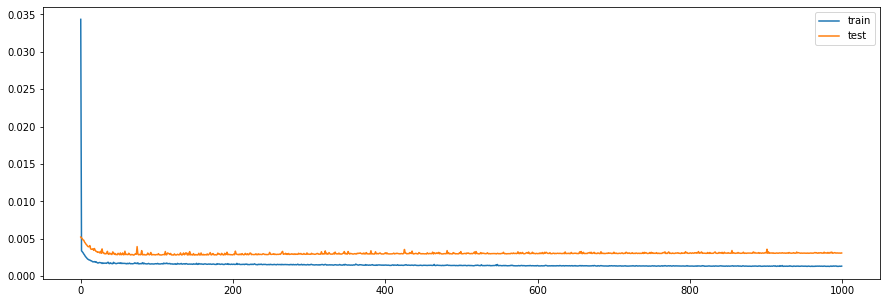

In [10]:
# plot history
plt.figure(figsize=(15,5))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [11]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [12]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [13]:
# calculate root mean squared error
trainrmse = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train RMSE: %.2f' % (trainrmse))
testrmse = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test RMSE: %.2f' % (testrmse))

Train RMSE: 32.29
Test RMSE: 49.93


In [14]:
# calculate MAPE
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true-y_pred)/y_true))*100

trainmape = mape(trainY[0], trainPredict[:,0])
print('Train MPAE: %.2f' % (trainmape))
testmape = mape(testY[0], testPredict[:,0])
print('Test MAPE: %.2f' % (testmape))

Train MPAE: 5.36
Test MAPE: 28.67


In [15]:
# calculate MAE
def mae(y_true, y_pred):
    return np.mean(np.abs((y_true-y_pred)))

trainmae = mae(trainY[0], trainPredict[:,0])
print('Train MAE: %.2f' % (trainmae))
testmae = mae(testY[0], testPredict[:,0])
print('Test MAE: %.2f' % (testmae))

Train MAE: 24.41
Test MAE: 29.78


In [16]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

In [17]:
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

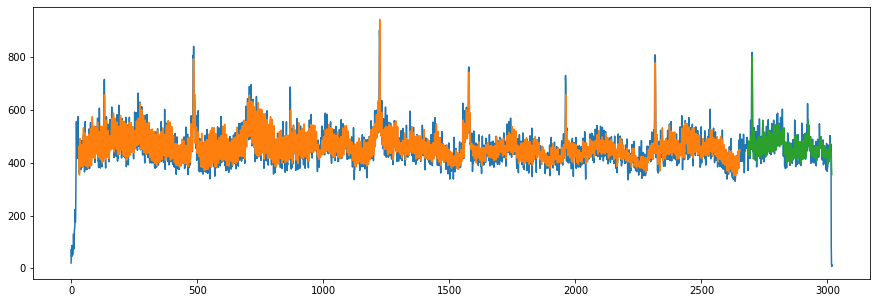

In [18]:
# plot baseline and predictions
plt.figure(figsize=(15,5))
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

Text(0.5, 1.0, 'Green stands for true values, Red stands for predictions')

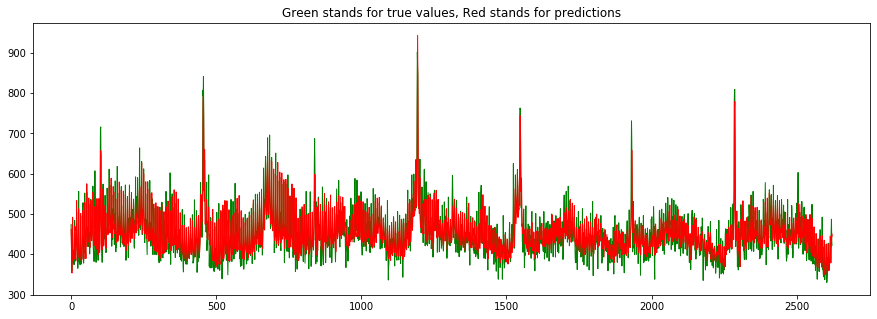

In [19]:
## plot training set for baseline and predictions
plt.figure(figsize=(15,5))
plt.plot(np.arange(len(trainY[0])), trainY[0], linewidth=1, color='g')
plt.plot(np.arange(len(trainPredict[:,0])), trainPredict[:,0], linewidth=1, color='r')
plt.title('Green stands for true values, Red stands for predictions')

Text(0.5, 1.0, 'Green stands for true values, Blue stands for predictions')

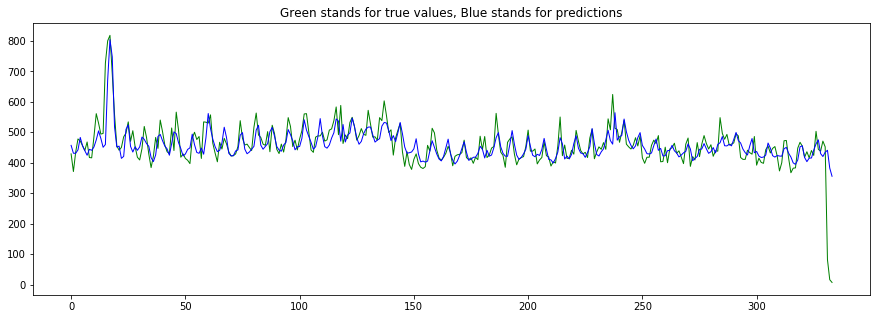

In [20]:
## plot testing set for baseline and predictions
plt.figure(figsize=(15,5))
plt.plot(np.arange(len(testY[0])), testY[0], linewidth=1, color='g')
plt.plot(np.arange(len(testPredict[:,0])), testPredict[:,0], linewidth=1, color='b')
plt.title('Green stands for true values, Blue stands for predictions')